# Multi-Group Neutron Diffusion

In this notebook, we will explore the multi-group neutron diffusion equation, which we learned about in class. We will use some standard Python libraries such as Numpy and Matplotlib. We will also use the [Scarabée](https://scarabee.readthedocs.io/en/latest/) library (written by Prof. Belanger) which has many tools for solving the multi-group neutron transport and diffusion equations.

First, we will import these libraries, and then get started.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scarabee as scb

## 2-Group Bare Slab

We will first start by defining the cross sections for the fuel region. The following values come from a previous Scarabée calculation performed on a PWR assembly:

|     | Group 1 | Group 2 |
| ----|---------|---------|
| $D$ | 1.4581530682272865 | 0.3837713399359353 |
| $\Sigma_a$ | 0.008862471276093381 | 0.08260759507461655 |
| $\nu\Sigma_f$ | 0.006281312892244154 | 0.1274795066006101 |
| $\Sigma_{s,1\to g}$ | 0.2571539243453326 | 0.01890832010182176 |
| $\Sigma_{s,2\to g}$ | 0.00135380638294217 | 0.9032096149462747 |
| $\chi$ | 1 | 0|
| $\nu$  | 2.43 | 2.43 |

*Because these 2-group cross sections come from a real lattice physics calculation for a real assembly, they may or may not align with the hypotheses used in class*. Using these values, we can create a `DiffusionCrossSection` object from Scarabée.

In [2]:
D  = np.array([1.4581530682272865, 0.3837713399359353])
Es = np.array([[0.2571539243453326, 0.01890832010182176],
               [0.00135380638294217, 0.9032096149462747]])
Ea  = np.array([0.008862471276093381, 0.08260759507461655])
vEf = np.array([0.006281312892244154, 0.1274795066006101])
Ef = vEf / 2.43
chi = np.array([1., 0.])

Fuel = scb.DiffusionCrossSection(D, Ea, Es, Ef, vEf, chi, name='Fuel')

In class, we found that the solution for the scaral flux in a bare critical slab (making certain assumptions) could be written as

$$ \phi_1(x) = A\cos(\chi x) $$
$$ \phi_2(x) = A \frac{D_1\chi^2 + \Sigma_{r,1}}{\nu\Sigma_{f,2}}\cos(\chi x) $$

where $\chi^2 = \alpha^2$, and $\alpha^2$ is taken to be the positive root of the following quadratic equation:

$$ L_1^2 L_2^2 (\alpha^2)^2 + (L_1^2 + L_2^2)(\alpha^2) - (k_\infty - 1) = 0$$

where $L_1^2 \equiv D_1 / \Sigma_{r,1}$, $L_2^2 \equiv D_2 / \Sigma_{a,2}$, and $k_\infty = \Sigma_{s,1\to 2}\nu\Sigma_{f,2}/(\Sigma_{r,1}\Sigma_{a,2})$. Let's define these quantities as Python variables, and then solve for $\alpha^2$ using the Pythagorean theorem.

In [3]:
L_1_sqrd = Fuel.D(0) / Fuel.Er(0)
L_2_sqrd = Fuel.D(1) / Fuel.Ea(1)
k_infty  = Fuel.Es(0,1) * Fuel.vEf(1) / (Fuel.Er(0) * Fuel.Ea(1))
print(f"k_infty = {k_infty}")
print()

# We check that we are able to have a valid reactor
assert k_infty > 1, "k_infty must be > 0, otherwise we cannot make a critical reactor"

a = L_1_sqrd * L_2_sqrd
b = L_1_sqrd + L_2_sqrd
c = -(k_infty - 1.)

alpha_sqrd = (-b + np.sqrt(b*b - 4.*a*c)) / (2. * a)
print(f"alpha^2 = chi^2 = {alpha_sqrd}")

k_infty = 1.0507153695379874

alpha^2 = chi^2 = 0.0008840347086571865


Using these obtained values, we can determine what the critical length of our slab reactor should be, as we will remember that for criticality, we required
$$ \chi^2 = \left(\frac{\pi}{2a}\right)^2 $$
which means that the critical slab half-length is
$$ a = \frac{\pi}{2\chi} $$

In [4]:
chi = np.sqrt(alpha_sqrd)
a = np.pi / (2. * chi)
print(f"a = {a} is the critical slab half-length")

a = 52.830560559307976 is the critical slab half-length


Now, lets define Numpy arrays with our analytical solutions for the flux, assuming $A=1$:

In [5]:
x = np.linspace(start=-a, stop=a, num=10000)
phi_1_analytic = np.cos(chi * x)
phi_2_analytic = ((Fuel.D(0)*chi*chi + Fuel.Er(0))/(Fuel.vEf(1))) * np.cos(chi * x)

### Numeric Solution

Now, we will use Scarabée to obtain a numerical solution to the 2-group bare slab problem. Don't worry if you don't understand all of the following lines of code. It is simply setting up a `solver` object which will solve the diffusion equation for us, and tell us what $k_\text{eff}$ is based on our provided cross sections and problem `geometry`.

In [6]:
len_numerical = 2.*a

# First, we define our 1D problem geometry using 3D, but reflective boundary conditions along y and z
geometry = scb.DiffusionGeometry([Fuel],        # A slab with a single material region: the Fuel we previously defined
                                 [len_numerical], # Total width of our bare fuel slab
                                 [1000],   # Number of regions to divide the slab into
                                 [1.],     # 1cm width along y
                                 [1],      # 1 region along y
                                 [1.],     # 1cm width along z
                                 [1],      # 1 region along z
                                 0.,       # The albedo on the -x boundary is 0 (i.e. vacuum boundary condition)
                                 0.,       # The albedo on the +x boundary is 0 (i.e. vacuum boundary condition)
                                 1.,       # The albedo on the -y boundary is 1 (i.e. refletive boundary condition)
                                 1.,       # The albedo on the +y boundary is 1 (i.e. refletive boundary condition)
                                 1.,       # The albedo on the -z boundary is 1 (i.e. refletive boundary condition)
                                 1.)       # The albedo on the +z boundary is 1 (i.e. refletive boundary condition)

# Next we define the diffusion solver
solver = scb.NEMDiffusionDriver(geometry)
scb.set_logging_level(scb.LogLevel.Warning) # This solver is realllly fast, and it will make Jupyter complain if we write all the output
solver.solve()
scb.set_logging_level(scb.LogLevel.Info) # Back to the normal print level
print(f"\n keff = {solver.keff} \n")


 keff = 1.2183082482329677 



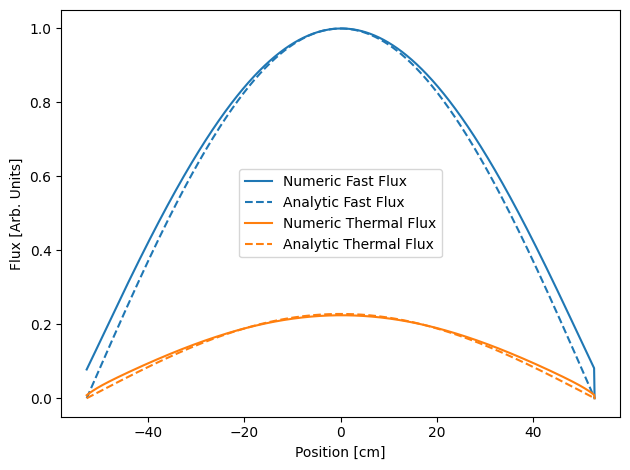

In [7]:
# We can ask the solver to give us the flux at all desired points
x_numerical = np.linspace(start=0., stop=len_numerical, num=1000)
flux = solver.flux(x_numerical, [0.], [0.])
x_numerical -= 0.5*len_numerical

# Get flux at mid-point of reactor in group 1 so we can normalize our numerical solution
norm = solver.flux([0.5*len_numerical], [0.], [0.])[0,0,0,0]

phi_1_numerical = flux[0,:,0,0] / norm
phi_2_numerical = flux[1,:,0,0] / norm


plt.plot(x_numerical, phi_1_numerical, label="Numeric Fast Flux", c='C0')
plt.plot(x, phi_1_analytic,  label="Analytic Fast Flux", c='C0', linestyle='--')
plt.plot(x_numerical, phi_2_numerical, label="Numeric Thermal Flux", c='C1')
plt.plot(x, phi_2_analytic,  label="Analytic Thermal Flux", c='C1', linestyle='--')
plt.legend()
plt.xlabel('Position [cm]')
plt.ylabel('Flux [Arb. Units]')
plt.tight_layout()
plt.show()

While our analytic solution required the reactor be exactly critical, our numeric solution found that $k_\text{eff} \approx 1.21831$, which is quite far away from criticality. I certainly would not want to be staning next to this nuclear reactor ! When comparing the plotted flux, we also see that while the value of the fast and thermal flux at the mid-point of the reactor are in agreement, the shapes are different !

### Questions

1) Above and in class, we provided a formula for $k_\infty$ in a homogeneous system. Is that formula valid in this case ? If not, why ?

2) Can you explain why our analytic solution is so different from the numerical solution ? Which one do you think is more accurate ?
   
3) By modifying the above code for the numeric solver, can you find the length which results in the numeric simulation being critical ?
   You only need to modify the line `len_numerical = 2.*a`, chaning it to the new slab length you would like to try, and then re-running the code block.

## 2-Group Reflected Slab

For fun, we can also simulate a 2-group slab reactor with a reflector ! Here are 2-group cross sections calculated for a PWR reflector region (including the homogenized baffel):

|    | Group 1 | Group 2 |
| ---|---------|---------|
| $D$ | 1.2567164488918514 | 0.2830988051250021 |
| $\Sigma_a$ | 0.0022491197930335975 | 0.029842704408969554 |
| $\Sigma_{s,1\to g}$ | 0.333059118129353 | 0.029891965362423445 |
| $\Sigma_{s,2\to g}$ | 0.0005884610659191085 | 1.2974482918223433 |

Feel free to play with the following block of code to modify the width of the fuel slab, the width of the reflectors, and see how that changes $k_\text{eff}$ and the flux shape. You could even try something really funny, like making one reflector larger than the other. With numerical solvers like these, you have a virtual nuclear reactor at your finger tips !


 keff = 1.0000000024005056 



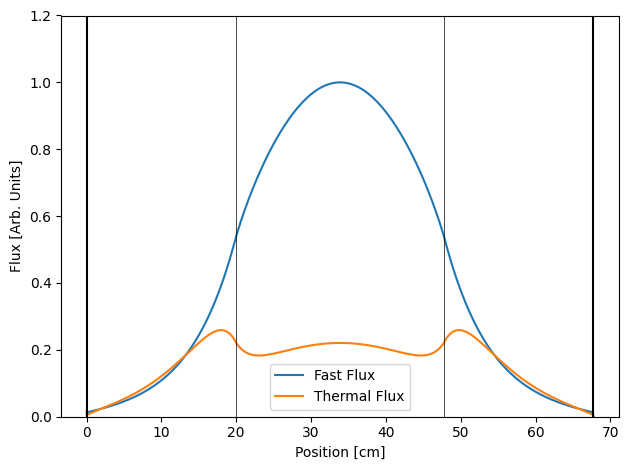

In [8]:
D  = np.array([1.2567164488918514, 0.2830988051250021])
Es = np.array([[0.333059118129353, 0.029891965362423445],
               [0.0005884610659191085, 1.2974482918223433]])
Ea  = np.array([0.0022491197930335975, 0.029842704408969554])

Ref = scb.DiffusionCrossSection(D, Ea, Es, name='Reflector')


fuel_len = 27.74407
ref_len = 20.

# First, we define our 1D problem geometry using 3D, but reflective boundary conditions along y and z
geometry = scb.DiffusionGeometry([Ref, Fuel, Ref],  # Reflector region, Fuel region, then Reflector region
                                 [ref_len, fuel_len, ref_len], # Width of each material segment
                                 [50, 50, 50],   # Number of regions for each material segment
                                 [1.],     # 1cm width along y
                                 [1],      # 1 region along y
                                 [1.],     # 1cm width along z
                                 [1],      # 1 region along z
                                 0.,       # The albedo on the -x boundary is 0 (i.e. vacuum boundary condition)
                                 0.,       # The albedo on the +x boundary is 0 (i.e. vacuum boundary condition)
                                 1.,       # The albedo on the -y boundary is 1 (i.e. refletive boundary condition)
                                 1.,       # The albedo on the +y boundary is 1 (i.e. refletive boundary condition)
                                 1.,       # The albedo on the -z boundary is 1 (i.e. refletive boundary condition)
                                 1.)       # The albedo on the +z boundary is 1 (i.e. refletive boundary condition)

# Next we define the diffusion solver
solver = scb.NEMDiffusionDriver(geometry)
scb.set_logging_level(scb.LogLevel.Warning) # This solver is realllly fast, and it will make Jupyter complain if we write all the output
solver.solve()
scb.set_logging_level(scb.LogLevel.Info) # Back to the normal print level
print(f"\n keff = {solver.keff} \n")

# We can ask the solver to give us the flux at all desired points
x = np.linspace(start=0., stop=fuel_len + 2.*ref_len, num=1000)
flux = solver.flux(x, [0.], [0.])
x_numerical -= 0.5*fuel_len + ref_len

# Get flux at mid-point of reactor in group 1 so we can normalize our numerical solution
norm = solver.flux([0.5*fuel_len + ref_len], [0.], [0.])[0,0,0,0]

phi_1_numerical = flux[0,:,0,0] / norm
phi_2_numerical = flux[1,:,0,0] / norm

plt.plot(x, phi_1_numerical,  label="Fast Flux", c='C0')
plt.plot(x, phi_2_numerical,  label="Thermal Flux", c='C1')
plt.plot([0., 0.], [0., 1.5], c='black')
plt.plot([ref_len, ref_len], [0., 1.5], c='black', linewidth=0.5)
plt.plot([ref_len+fuel_len, ref_len+fuel_len], [0., 1.5], c='black', linewidth=0.5)
plt.plot([fuel_len + 2.*ref_len, fuel_len + 2.*ref_len], [0., 1.5], c='black')
plt.legend()
plt.xlabel('Position [cm]')
plt.ylabel('Flux [Arb. Units]')
plt.ylim([0, 1.2])
plt.tight_layout()
plt.show()